In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from gplearn.genetic import SymbolicClassifier
from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [3]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None):
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names == None:
            function_vars = function.atoms(Symbol)
        else:
            function_vars = [sym.symbols(variable_name) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        function_values = []
        for data_point in data_points:
            function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
            try:
                function_value = float(function_value)
            except TypeError as te:
                #print(te)
                #print(function_value)
                function_value = np.inf
            function_values.append(function_value)
    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

In [4]:
def print_decision_tree_nodes(decision_tree): 
    
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

## Load Histograms and Data Statistics

In [5]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [6]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000,-3.043901,-1.0,9.212087,110.625000,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.138240,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625000,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [7]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [8]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [9]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [10]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [11]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [12]:
summarizing_statistics_replica

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[4.05498868e+00 1.61819320e+00 1.43801350e+00...
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,[[ 4.60037788e+00 1.66251134e+00 1.59768757e...
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,[[ 1.53948274e+00 2.18804150e-01 7.78027734e...
off_replica,16741535,-2.791476,4.517446,-1.396657,107.331233,-9.894227,-37.217121,-4.272182,0.000004,8.534652,106.621120,4.482172,2402.991829,[[ 1.77712398e+00 9.46578975e-02 8.42137846e...
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[8.46656243e+00 1.04568770e+01 3.70312553e+00...
all_replica,26381042,-0.944794,6.939326,-0.547978,111.501253,-9.894227,-37.217121,-4.272182,0.000004,10.007755,117.621411,6.767623,2402.992395,[[8.73149553e+00 8.43511366e+00 3.84013568e+00...


In [13]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [14]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [15]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [16]:
pump_data_replica.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
count,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07
mean,-9.447940e-01,6.939326e+00,-5.479782e-01,1.115013e+02,3.653952e-01
std,2.954910e+00,9.601276e+00,1.405716e+00,1.955450e+02,4.815408e-01
min,-9.894227e+00,-3.721712e+01,-4.272182e+00,4.127640e-06,0.000000e+00
25%,-3.370405e+00,1.604177e+00,-1.820977e+00,3.802474e+01,0.000000e+00
50%,-2.187935e+00,4.925814e+00,-9.364350e-01,7.603595e+01,0.000000e+00
75%,1.350188e+00,8.836291e+00,5.890964e-01,1.140709e+02,1.000000e+00
max,1.000776e+01,1.176214e+02,6.767623e+00,2.402992e+03,1.000000e+00


In [17]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [18]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

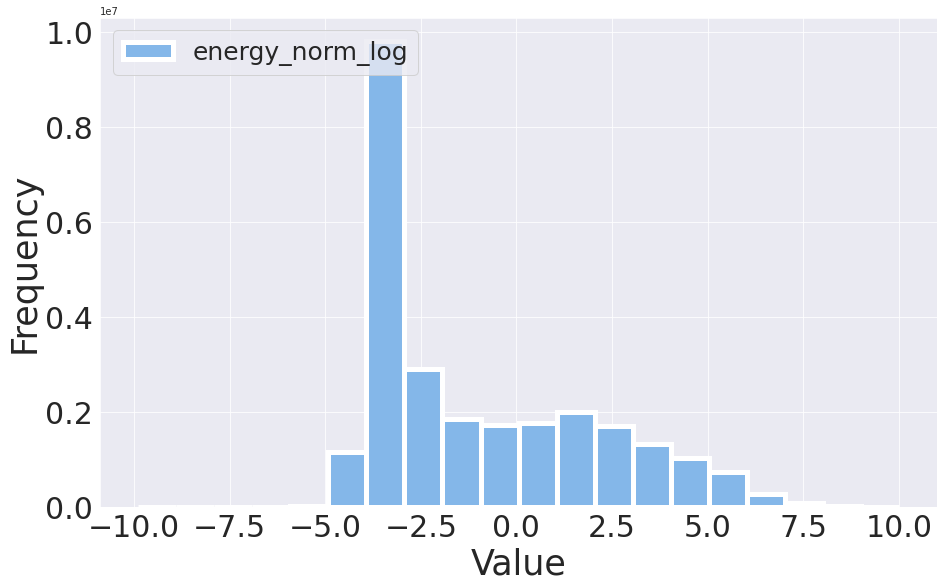

In [19]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

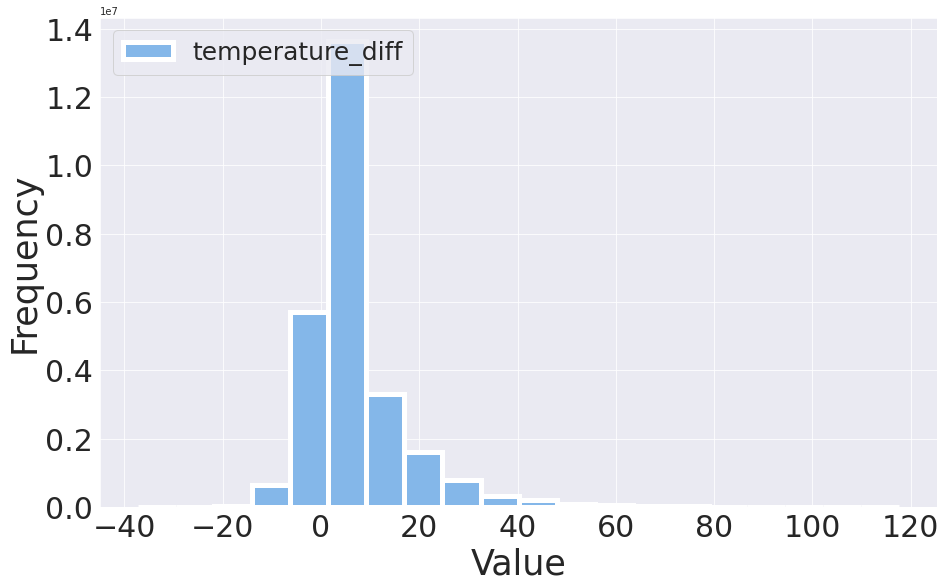

In [20]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

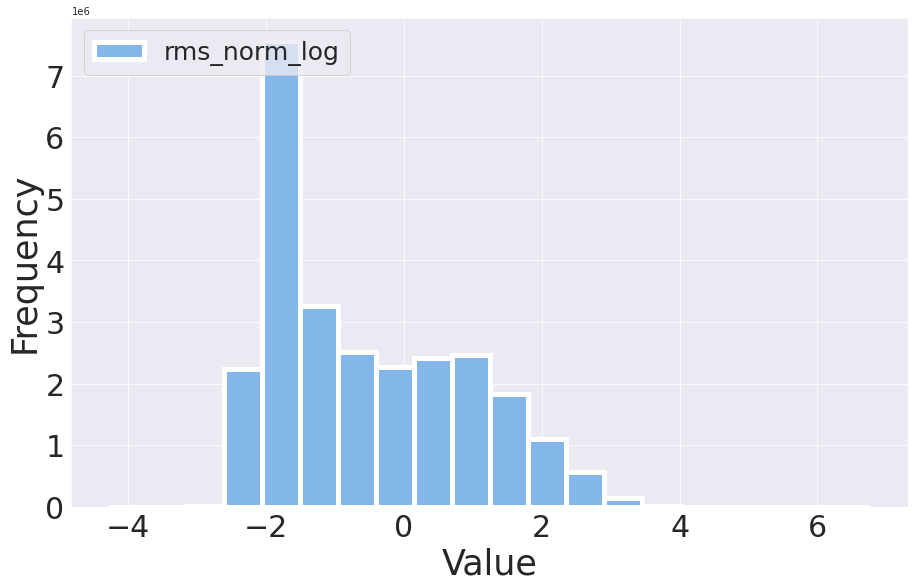

In [21]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

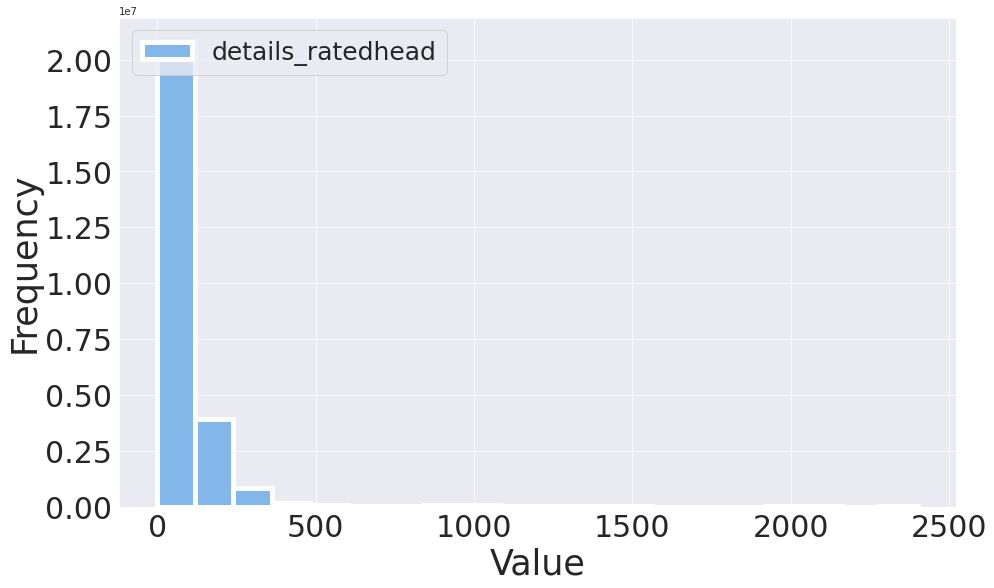

In [22]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [23]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [24]:
data = pump_data_replica.sample(n=10000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1


In [25]:
X_data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,-3.435427,2.008345,-1.831309,44.514913
13018525,-3.043470,4.328306,-2.011905,57.427111
22758968,0.059526,3.589398,0.421158,32.645146
26049008,-3.589604,2.368120,-2.103114,466.114163
4688620,0.485113,9.553305,1.172251,54.346425


In [26]:
y_data.head()

,state
13880350,0
13018525,0
22758968,0
26049008,0
4688620,1


In [27]:
X_data.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.903752,6.957620,-0.529029,108.840560
std,2.940251,9.583776,1.391853,179.754406
min,-5.676228,-22.095298,-2.981257,0.004160
25%,-3.347392,1.625078,-1.804050,38.281687
50%,-2.114641,4.917930,-0.892979,77.509069
75%,1.360277,8.790616,0.605675,114.241249
max,8.326624,108.964905,3.778478,2379.037789


In [28]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 13880350 to 9629643
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy_norm_log    10000 non-null  float64
 1   temperature_diff   10000 non-null  float64
 2   rms_norm_log       10000 non-null  float64
 3   details_ratedhead  10000 non-null  float64
dtypes: float64(4)
memory usage: 390.6 KB


# Symbolic Metamodeling

In [29]:
metamodeling_hyperparams = {
    'num_iter': 10,#500,
    'batch_size': None,
    'learning_rate': 0.001,        
    'dataset_size': 5000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 20,
    'restarts': 3,
}

symbolic_classification_hyperparams = {     
    'dataset_size': 5000,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True
symbolic_classification = True

In [30]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.9024

In [31]:
data = pump_data_replica.sample(n=metamodeling_hyperparams['dataset_size'])

data_scaled = np.empty_like(data.values.T[:-1])
scaler_list = []

for index, feature in enumerate(data.values.T[:-1]):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    data_scaled[index] = feature_scaled
    
data_scaled = pd.DataFrame(data= data_scaled.T, index=data.index, columns=list(data.columns)[:-1])

In [32]:
data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
3228774,0.722642,5.048562,0.478871,102.441835,1
6648753,2.069493,24.442959,1.769626,66.284119,1
25558960,-1.145248,4.071129,-0.063827,184.503801,0
17578382,-3.199043,4.780609,-1.628835,27.827720,0
4363318,1.854438,2.216334,0.973370,60.624418,1


In [33]:
data_scaled.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
3228774,0.444761,0.210039,0.513313,0.042952
6648753,0.543485,0.410551,0.707789,0.027825
25558960,0.307845,0.199934,0.431546,0.077285
17578382,0.157302,0.207269,0.195749,0.011735
4363318,0.527721,0.180758,0.587818,0.025457


In [34]:
X_data = data.drop(['state'], axis=1).values #frac=0.1
y_data = data[['state']].values #frac=0.1

X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   


In [35]:
X_data_scaled = data_scaled.values 
X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

In [36]:
print(X_data.shape)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()

print(y_data.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(5000, 4)
(2812, 4)
(938, 4)
(1250, 4)

(5000, 1)
(2812, 1)
(938, 1)
(1250, 1)


## Evaluate Model

In [37]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))


Accuracy: 0.904


In [38]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train, 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [39]:
%load_ext autoreload 

In [40]:
if False:
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from xgboost import XGBClassifier
    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split


    data          = pd.read_csv("data/absenteeism.csv", delimiter=';')

    feature_names = ['Transportation expense', 'Distance from Residence to Work',
                     'Service time', 'Age', 'Work load Average/day ', 'Hit target',
                     'Disciplinary failure', 'Education', 'Son', 'Social drinker',
                     'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']

    scaler        = MinMaxScaler(feature_range=(0, 1))
    X             = scaler.fit_transform(data[feature_names])
    Y             = ((data['Absenteeism time in hours'] > 4) * 1) 

    X_train_abse, X_test_abse, Y_train_abse, Y_test_abse = train_test_split(X, Y, test_size=0.33, random_state=42)

    model         = XGBClassifier()

    model.fit(X_train_abse, Y_train_abse)

In [41]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]:  
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [42]:
#print_decision_tree_nodes(random_forest_model.estimators_[0])

In [43]:
#print_decision_tree_nodes(random_forest_model_resized.estimators_[0])

In [44]:
%autoreload 2
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled, #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]


restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.636
Iteration: 1 	--- Loss: 37.453
Iteration: 2 	--- Loss: 35.981
Iteration: 3 	--- Loss: 34.626
Iteration: 4 	--- Loss: 36.266
Iteration: 5 	--- Loss: 35.120
Iteration: 6 	--- Loss: 38.104
Iteration: 7 	--- Loss: 35.600
Iteration: 8 	--- Loss: 36.212
Iteration: 9 	--- Loss: 35.084
Iteration: 10 	--- Loss: 35.015
Iteration: 11 	--- Loss: 36.048
Iteration: 12 	--- Loss: 34.742
Iteration: 13 	--- Loss: 35.623
Iteration: 14 	--- Loss: 35.950
Iteration: 15 	--- Loss: 35.751
Iteration: 16 	--- Loss: 36.136
Iteration: 17 	--- Loss: 35.778
Iteration: 18 	--- Loss: 35.142
Iteration: 19 	--- Loss: 36.639
Iteration: 20 	--- Loss: 36.340
Iteration: 21 	--- Loss: 35.875
Iteration: 22 	--- Loss: 36.613
Iteration: 23 	--- Loss: 35.357



restart loop:  25%|██▌       | 1/4 [00:04<00:13,  4.34s/it]

Iteration: 24 	--- Loss: 35.875
Early Stopping requirement reached after 24 Iterations
New Global Minimum: 34.626171362901516


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.461
Iteration: 1 	--- Loss: 34.105
Iteration: 2 	--- Loss: 33.247
Iteration: 3 	--- Loss: 35.914
Iteration: 4 	--- Loss: 33.734
Iteration: 5 	--- Loss: 34.660
Iteration: 6 	--- Loss: 33.323
Iteration: 7 	--- Loss: 35.063
Iteration: 8 	--- Loss: 36.035
Iteration: 9 	--- Loss: 35.263
Iteration: 10 	--- Loss: 37.566
Iteration: 11 	--- Loss: 39.163
Iteration: 12 	--- Loss: 34.382
Iteration: 13 	--- Loss: 38.010
Iteration: 14 	--- Loss: 36.699
Iteration: 15 	--- Loss: 34.298
Iteration: 16 	--- Loss: 34.669
Iteration: 17 	--- Loss: 38.407
Iteration: 18 	--- Loss: 33.252
Iteration: 19 	--- Loss: 34.616
Iteration: 20 	--- Loss: 36.266
Iteration: 21 	--- Loss: 33.432
Iteration: 22 	--- Loss: 34.287



restart loop:  50%|█████     | 2/4 [00:07<00:07,  3.86s/it]

Iteration: 23 	--- Loss: 35.910
Early Stopping requirement reached after 23 Iterations
New Global Minimum: 33.24683097343034


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.883
Iteration: 1 	--- Loss: 35.240
Iteration: 2 	--- Loss: 38.105
Iteration: 3 	--- Loss: 36.077
Iteration: 4 	--- Loss: 34.529
Iteration: 5 	--- Loss: 36.772
Iteration: 6 	--- Loss: 35.969
Iteration: 7 	--- Loss: 35.913
Iteration: 8 	--- Loss: 36.954
Iteration: 9 	--- Loss: 35.931
Iteration: 10 	--- Loss: 34.993
Iteration: 11 	--- Loss: 35.916
Iteration: 12 	--- Loss: 36.227
Iteration: 13 	--- Loss: 32.759
Iteration: 14 	--- Loss: 38.474
Iteration: 15 	--- Loss: 33.868
Iteration: 16 	--- Loss: 36.220
Iteration: 17 	--- Loss: 35.493
Iteration: 18 	--- Loss: 35.877
Iteration: 19 	--- Loss: 34.576
Iteration: 20 	--- Loss: 35.681
Iteration: 21 	--- Loss: 36.814
Iteration: 22 	--- Loss: 36.827
Iteration: 23 	--- Loss: 35.514
Iteration: 24 	--- Loss: 33.723
Iteration: 25 	--- Loss: 32.894
Iteration: 26 	--- Loss: 35.834
Iteration: 27 	--- Loss: 37.391
Iteration: 28 	--- Loss: 36.540
Iteration: 29 	--- Loss: 32.410
Iteration: 30 	--- Loss: 33.462
Iteration: 31 	---


restart loop:  75%|███████▌  | 3/4 [00:20<00:07,  7.68s/it]

Iteration: 42 	--- Loss: 79072596542919201996224331776.000
BREAK tune_single_dim
func_true 321105990080405.75
y[batch_index] -7.810986758395461
a_new, b_new, c_new 8.727611999936621e+29 -9.261022219141107e+29 1.5829845603266343e+28
New Global Minimum: 32.410026478359015


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.649
Wrong c Value: -0.015974636799909847



restart loop: 100%|██████████| 4/4 [00:20<00:00,  5.14s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 1 	--- Loss: 36.944
BREAK tune_single_dim
func_true 2.869816948499447e-05
y[batch_index] 5.810045946157598
a_new, b_new, c_new nan nan nan
return abc 2.2045079026864856 0.7054666028997569 -0.015974636799909847


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.201
Iteration: 1 	--- Loss: 36.761
Iteration: 2 	--- Loss: 40.315
Iteration: 3 	--- Loss: 38.246
Iteration: 4 	--- Loss: 37.050
Iteration: 5 	--- Loss: 37.284
Iteration: 6 	--- Loss: 37.963
Iteration: 7 	--- Loss: 37.075
Iteration: 8 	--- Loss: 36.176
Iteration: 9 	--- Loss: 37.969
Iteration: 10 	--- Loss: 36.098
Iteration: 11 	--- Loss: 37.960
Iteration: 12 	--- Loss: 36.370
Iteration: 13 	--- Loss: 36.213
Iteration: 14 	--- Loss: 36.423
Iteration: 15 	--- Loss: 37.096
Iteration: 16 	--- Loss: 35.610
Iteration: 17 	--- Loss: 39.093
Iteration: 18 	--- Loss: 34.841
Iteration: 19 	--- Loss: 38.825
Iteration: 20 	--- Loss: 37.411
Iteration: 21 	--- Loss: 37.817
Iteration: 22 	--- Loss: 37.189
Iteration: 23 	--- Loss: 37.644
Iteration: 24 	--- Loss: 35.744
Iteration: 25 	--- Loss: 38.663
Iteration: 26 	--- Loss: 40.817
Iteration: 27 	--- Loss: 36.782
Iteration: 28 	--- Loss: 38.191
Iteration: 29 	--- Loss: 35.426
Iteration: 30 	--- Loss: 37.065
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [00:05<00:17,  5.94s/it]

Iteration: 39 	--- Loss: 36.780
Early Stopping requirement reached after 39 Iterations
New Global Minimum: 34.84054265823563


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.962
Iteration: 1 	--- Loss: 38.211
Iteration: 2 	--- Loss: 39.359
Iteration: 3 	--- Loss: 38.428
Iteration: 4 	--- Loss: 36.742
Iteration: 5 	--- Loss: 38.105
Iteration: 6 	--- Loss: 37.894
Iteration: 7 	--- Loss: 36.736
Iteration: 8 	--- Loss: 36.003
Iteration: 9 	--- Loss: 37.839
Iteration: 10 	--- Loss: 36.414
Iteration: 11 	--- Loss: 36.644
Iteration: 12 	--- Loss: 37.343
Iteration: 13 	--- Loss: 38.158
Iteration: 14 	--- Loss: 37.621
Iteration: 15 	--- Loss: 38.730
Iteration: 16 	--- Loss: 38.328
Iteration: 17 	--- Loss: 37.095
Iteration: 18 	--- Loss: 34.702
Iteration: 19 	--- Loss: 34.368
Iteration: 20 	--- Loss: 33.647
Iteration: 21 	--- Loss: 30.559



restart loop:  50%|█████     | 2/4 [00:09<00:08,  4.43s/it]

Iteration: 22 	--- Loss: 94487.635
BREAK tune_single_dim
func_true 247.2545721090164
y[batch_index] 4.271899779433679
a_new, b_new, c_new 36096.03551336669 154139.30828209085 697892.0261875406
New Global Minimum: 30.559200324239594


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.579
Iteration: 1 	--- Loss: 35.573
Iteration: 2 	--- Loss: 37.503
Iteration: 3 	--- Loss: 37.341
Iteration: 4 	--- Loss: 37.694
Iteration: 5 	--- Loss: 36.175
Iteration: 6 	--- Loss: 35.016
Iteration: 7 	--- Loss: 36.207
Iteration: 8 	--- Loss: 36.352
Iteration: 9 	--- Loss: 36.830
Iteration: 10 	--- Loss: 36.917
Iteration: 11 	--- Loss: 38.279
Iteration: 12 	--- Loss: 35.553
Iteration: 13 	--- Loss: 36.370
Iteration: 14 	--- Loss: 36.552
Iteration: 15 	--- Loss: 36.878
Iteration: 16 	--- Loss: 39.911
Iteration: 17 	--- Loss: 36.884
Iteration: 18 	--- Loss: 37.295
Iteration: 19 	--- Loss: 39.015
Iteration: 20 	--- Loss: 35.912
Iteration: 21 	--- Loss: 36.529
Iteration: 22 	--- Loss: 34.767
Iteration: 23 	--- Loss: 36.498
Iteration: 24 	--- Loss: 34.795
Iteration: 25 	--- Loss: 38.726
Iteration: 26 	--- Loss: 37.536
Iteration: 27 	--- Loss: 36.600
Iteration: 28 	--- Loss: 34.642
Iteration: 29 	--- Loss: 37.997
Iteration: 30 	--- Loss: 39.155
Iteration: 31 	---


restart loop:  75%|███████▌  | 3/4 [00:17<00:06,  6.20s/it]

Iteration: 56 	--- Loss: 35.789
Early Stopping requirement reached after 56 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.229
Iteration: 1 	--- Loss: 39.979
Iteration: 2 	--- Loss: 40.022
Iteration: 3 	--- Loss: 35.984
Iteration: 4 	--- Loss: 40.051
Iteration: 5 	--- Loss: 39.453
Iteration: 6 	--- Loss: 41.300
Iteration: 7 	--- Loss: 38.109
Iteration: 8 	--- Loss: 37.647
Iteration: 9 	--- Loss: 37.843
Iteration: 10 	--- Loss: 37.915
Iteration: 11 	--- Loss: 37.108
Iteration: 12 	--- Loss: 38.810
Iteration: 13 	--- Loss: 34.812
Iteration: 14 	--- Loss: 35.837
Iteration: 15 	--- Loss: 36.200
Iteration: 16 	--- Loss: 37.225
Iteration: 17 	--- Loss: 35.811
Iteration: 18 	--- Loss: 37.468
Iteration: 19 	--- Loss: 37.400
Iteration: 20 	--- Loss: 37.820
Iteration: 21 	--- Loss: 35.543
Iteration: 22 	--- Loss: 35.302
Iteration: 23 	--- Loss: 37.001
Iteration: 24 	--- Loss: 35.379
Iteration: 25 	--- Loss: 36.993
Iteration: 26 	--- Loss: 35.963
Iteration: 27 	--- Loss: 38.553
Iteration: 28 	--- Loss: 36.300
Iteration: 29 	--- Loss: 36.642
Iteration: 30 	--- Loss: 36.731
Iteration: 31 	---


restart loop: 100%|██████████| 4/4 [00:23<00:00,  5.75s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 34 	--- Loss: 37.775
Early Stopping requirement reached after 34 Iterations
return abc 2.348881077647865 1.4704994270017269 0.7943802018763488


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.610
Iteration: 1 	--- Loss: 36.033
Iteration: 2 	--- Loss: 38.267
Iteration: 3 	--- Loss: 36.749
Iteration: 4 	--- Loss: 35.637
Iteration: 5 	--- Loss: 34.754
Iteration: 6 	--- Loss: 36.659
Iteration: 7 	--- Loss: 34.098
Iteration: 8 	--- Loss: 37.955
Iteration: 9 	--- Loss: 35.330
Iteration: 10 	--- Loss: 37.263
Iteration: 11 	--- Loss: 35.396
Iteration: 12 	--- Loss: 34.685
Iteration: 13 	--- Loss: 34.751
Iteration: 14 	--- Loss: 39.776
Iteration: 15 	--- Loss: 38.442
Iteration: 16 	--- Loss: 34.714
Iteration: 17 	--- Loss: 36.372
Iteration: 18 	--- Loss: 34.915
Iteration: 19 	--- Loss: 32.853
Iteration: 20 	--- Loss: 34.491
Iteration: 21 	--- Loss: 36.904
Iteration: 22 	--- Loss: 33.783
Iteration: 23 	--- Loss: 35.056
Iteration: 24 	--- Loss: 36.193
Iteration: 25 	--- Loss: 34.142
Iteration: 26 	--- Loss: 34.633
Iteration: 27 	--- Loss: 36.544
Iteration: 28 	--- Loss: 33.134
Iteration: 29 	--- Loss: 33.839
Iteration: 30 	--- Loss: 33.627
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [00:11<00:34, 11.55s/it]

Iteration: 43 	--- Loss: 41.935
BREAK tune_single_dim
func_true -0.03652418230344878
y[batch_index] -3.139750106044294
a_new, b_new, c_new -141.72475609973333 -846.7114745217517 -879.3041536844638
New Global Minimum: 32.5791393838792


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.095
Iteration: 1 	--- Loss: 37.268
Iteration: 2 	--- Loss: 35.608
Iteration: 3 	--- Loss: 37.214
Iteration: 4 	--- Loss: 39.709
Iteration: 5 	--- Loss: 36.918
Iteration: 6 	--- Loss: 39.283
Iteration: 7 	--- Loss: 37.124
Iteration: 8 	--- Loss: 36.774
Iteration: 9 	--- Loss: 38.836
Iteration: 10 	--- Loss: 35.495
Iteration: 11 	--- Loss: 35.784
Iteration: 12 	--- Loss: 35.387
Iteration: 13 	--- Loss: 34.991
Iteration: 14 	--- Loss: 36.522
Iteration: 15 	--- Loss: 36.282
Iteration: 16 	--- Loss: 35.351
Iteration: 17 	--- Loss: 37.405
Iteration: 18 	--- Loss: 34.683
Iteration: 19 	--- Loss: 37.590
Iteration: 20 	--- Loss: 35.390
Iteration: 21 	--- Loss: 35.699
Iteration: 22 	--- Loss: 36.532
Iteration: 23 	--- Loss: 33.811
Iteration: 24 	--- Loss: 35.014
Iteration: 25 	--- Loss: 34.738
Iteration: 26 	--- Loss: 34.590
Iteration: 27 	--- Loss: 36.360
Iteration: 28 	--- Loss: 37.587
Iteration: 29 	--- Loss: 34.128
Iteration: 30 	--- Loss: 33.791
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [00:24<00:24, 12.23s/it]

Iteration: 45 	--- Loss: 16024983277435010053408695217256315503660573251523101580994218874318193339923474482332872396344459070510811292836800716796276658254465106424929210820287650886387946607345664.000
BREAK tune_single_dim
func_true -1.3249069987200228e+82
y[batch_index] 2.025701139475443
a_new, b_new, c_new 2.5120904157973693e+183 -3.3634372316080525e+183 1.610091519397232e+182
New Global Minimum: 31.950140185208205


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.454
Wrong c Value: -0.34731511346662347



restart loop:  75%|███████▌  | 3/4 [00:24<00:06,  6.87s/it]

Iteration: 1 	--- Loss: 38.366
BREAK tune_single_dim
func_true 0.003994838294182581
y[batch_index] -7.538434940703938
a_new, b_new, c_new nan nan nan


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.409
Iteration: 1 	--- Loss: 36.006
Iteration: 2 	--- Loss: 35.877
Iteration: 3 	--- Loss: 37.253
Iteration: 4 	--- Loss: 36.468
Iteration: 5 	--- Loss: 35.478
Iteration: 6 	--- Loss: 36.496
Iteration: 7 	--- Loss: 35.588
Iteration: 8 	--- Loss: 34.392
Iteration: 9 	--- Loss: 33.969
Iteration: 10 	--- Loss: 34.382
Iteration: 11 	--- Loss: 36.267
Iteration: 12 	--- Loss: 37.283
Iteration: 13 	--- Loss: 36.463
Iteration: 14 	--- Loss: 33.745
Iteration: 15 	--- Loss: 34.988
Iteration: 16 	--- Loss: 35.047
Iteration: 17 	--- Loss: 36.078
Iteration: 18 	--- Loss: 37.759
Iteration: 19 	--- Loss: 32.251
Iteration: 20 	--- Loss: 37.023
Iteration: 21 	--- Loss: 35.618
Iteration: 22 	--- Loss: 37.454
Iteration: 23 	--- Loss: 36.001
Iteration: 24 	--- Loss: 39.778
Iteration: 25 	--- Loss: 35.436
Iteration: 26 	--- Loss: 35.880
Iteration: 27 	--- Loss: 35.978
Iteration: 28 	--- Loss: 35.275
Iteration: 29 	--- Loss: 35.444
Iteration: 30 	--- Loss: 35.859
Iteration: 31 	---


restart loop: 100%|██████████| 4/4 [00:30<00:00,  7.74s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 40 	--- Loss: 35.117
Early Stopping requirement reached after 40 Iterations
return abc 3.1874642053255435 1.3043751253128 2.242274876835377


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.291
Iteration: 1 	--- Loss: 40.089
Iteration: 2 	--- Loss: 37.310
Iteration: 3 	--- Loss: 38.223
Iteration: 4 	--- Loss: 39.970
Iteration: 5 	--- Loss: 36.404
Iteration: 6 	--- Loss: 39.192
Iteration: 7 	--- Loss: 39.394
Iteration: 8 	--- Loss: 34.907
Iteration: 9 	--- Loss: 38.385
Iteration: 10 	--- Loss: 38.345
Iteration: 11 	--- Loss: 37.076
Iteration: 12 	--- Loss: 36.894
Iteration: 13 	--- Loss: 36.854
Iteration: 14 	--- Loss: 38.885
Iteration: 15 	--- Loss: 35.843
Iteration: 16 	--- Loss: 38.140
Iteration: 17 	--- Loss: 36.726
Iteration: 18 	--- Loss: 36.976
Iteration: 19 	--- Loss: 36.180
Iteration: 20 	--- Loss: 37.627
Iteration: 21 	--- Loss: 36.706
Iteration: 22 	--- Loss: 37.670
Iteration: 23 	--- Loss: 38.523
Iteration: 24 	--- Loss: 36.303
Iteration: 25 	--- Loss: 39.752
Iteration: 26 	--- Loss: 37.789
Iteration: 27 	--- Loss: 37.052
Iteration: 28 	--- Loss: 35.977



restart loop:  25%|██▌       | 1/4 [00:04<00:13,  4.59s/it]

Iteration: 29 	--- Loss: 37.136
Early Stopping requirement reached after 29 Iterations
New Global Minimum: 34.90687822955466


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.421
Iteration: 1 	--- Loss: 36.069
Iteration: 2 	--- Loss: 37.782
Iteration: 3 	--- Loss: 37.815
Iteration: 4 	--- Loss: 37.842
Iteration: 5 	--- Loss: 38.208
Iteration: 6 	--- Loss: 39.457
Iteration: 7 	--- Loss: 38.554
Iteration: 8 	--- Loss: 36.921
Iteration: 9 	--- Loss: 39.859
Iteration: 10 	--- Loss: 39.603
Iteration: 11 	--- Loss: 38.325
Iteration: 12 	--- Loss: 36.449
Iteration: 13 	--- Loss: 38.479
Iteration: 14 	--- Loss: 35.193
Iteration: 15 	--- Loss: 37.674
Iteration: 16 	--- Loss: 35.133
Iteration: 17 	--- Loss: 36.992
Iteration: 18 	--- Loss: 35.890
Iteration: 19 	--- Loss: 35.065
Iteration: 20 	--- Loss: 36.850
Iteration: 21 	--- Loss: 37.015
Iteration: 22 	--- Loss: 38.360
Iteration: 23 	--- Loss: 39.384
Iteration: 24 	--- Loss: 35.064
Iteration: 25 	--- Loss: 39.332
Iteration: 26 	--- Loss: 37.610
Iteration: 27 	--- Loss: 36.941
Iteration: 28 	--- Loss: 37.775
Iteration: 29 	--- Loss: 38.075
Iteration: 30 	--- Loss: 34.804
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [00:12<00:12,  6.42s/it]

Iteration: 51 	--- Loss: 38.846
Early Stopping requirement reached after 51 Iterations
New Global Minimum: 34.803905567565906


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.131
Iteration: 1 	--- Loss: 35.327
Iteration: 2 	--- Loss: 37.620
Iteration: 3 	--- Loss: 34.834
Iteration: 4 	--- Loss: 34.853
Iteration: 5 	--- Loss: 36.706
Iteration: 6 	--- Loss: 34.644
Iteration: 7 	--- Loss: 37.686
Iteration: 8 	--- Loss: 36.918
Iteration: 9 	--- Loss: 38.311
Iteration: 10 	--- Loss: 33.493
Iteration: 11 	--- Loss: 36.752
Iteration: 12 	--- Loss: 40.144
Iteration: 13 	--- Loss: 33.575
Iteration: 14 	--- Loss: 35.575
Iteration: 15 	--- Loss: 36.492
Iteration: 16 	--- Loss: 33.531
Iteration: 17 	--- Loss: 38.497
Iteration: 18 	--- Loss: 37.072
Iteration: 19 	--- Loss: 37.343
Iteration: 20 	--- Loss: 37.153
Iteration: 21 	--- Loss: 34.937
Iteration: 22 	--- Loss: 37.423
Iteration: 23 	--- Loss: 37.356
Iteration: 24 	--- Loss: 36.813
Iteration: 25 	--- Loss: 37.904
Iteration: 26 	--- Loss: 36.985
Iteration: 27 	--- Loss: 37.258
Iteration: 28 	--- Loss: 34.526
Iteration: 29 	--- Loss: 36.805



restart loop:  75%|███████▌  | 3/4 [00:17<00:06,  6.05s/it]

Iteration: 30 	--- Loss: 36.110
Iteration: 31 	--- Loss: 39.380
Early Stopping requirement reached after 31 Iterations
New Global Minimum: 33.492791518426806


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.291
Iteration: 1 	--- Loss: 38.298
Iteration: 2 	--- Loss: 37.836
Iteration: 3 	--- Loss: 38.408
Iteration: 4 	--- Loss: 37.152
Iteration: 5 	--- Loss: 37.543
Iteration: 6 	--- Loss: 37.758
Iteration: 7 	--- Loss: 36.124
Iteration: 8 	--- Loss: 36.454
Iteration: 9 	--- Loss: 38.931
Iteration: 10 	--- Loss: 36.699
Iteration: 11 	--- Loss: 34.495
Iteration: 12 	--- Loss: 37.127
Iteration: 13 	--- Loss: 39.158
Iteration: 14 	--- Loss: 34.637
Iteration: 15 	--- Loss: 38.047
Iteration: 16 	--- Loss: 37.075
Iteration: 17 	--- Loss: 37.397
Iteration: 18 	--- Loss: 38.296
Iteration: 19 	--- Loss: 36.552
Iteration: 20 	--- Loss: 37.884
Iteration: 21 	--- Loss: 35.307
Iteration: 22 	--- Loss: 35.439
Iteration: 23 	--- Loss: 34.385
Iteration: 24 	--- Loss: 37.421
Iteration: 25 	--- Loss: 36.095
Iteration: 26 	--- Loss: 39.544
Iteration: 27 	--- Loss: 39.813
Iteration: 28 	--- Loss: 35.970
Iteration: 29 	--- Loss: 38.976
Iteration: 30 	--- Loss: 40.752
Iteration: 31 	---


restart loop: 100%|██████████| 4/4 [00:24<00:00,  6.13s/it]

Iteration: 44 	--- Loss: 36.231
Early Stopping requirement reached after 44 Iterations
return abc -0.003960010400714975 1.6294397297300622 1.1725353535067602


----  Optimizing the metamodel  ----


  0%|          | 0/10 [00:00<?, ?it/s]



BREAK Params or Coef
curr_func [4.27635401e+159 1.11859151e+161 3.62759861e+160 ... 3.91668308e+160
 1.20314238e+161 1.19856022e+161]
param_grads [[ 3.62344080e+159 -1.32599654e+160 -2.16380943e+160]
 [             nan              nan              nan]
 [-9.35178830e+160  8.71767169e+160  1.13743681e+161]
 [ 1.76833349e+157  3.11333531e+159  1.91733947e+159]
 [ 1.32166412e+160  9.19680256e+158 -5.83870486e+159]
 [ 7.20279575e+159  1.12977518e+160 -8.73281688e+159]
 [ 2.78912027e+159  3.82876563e+158 -9.00535773e+158]
 [ 1.49735260e+160  1.05661264e+159 -6.82871248e+159]
 [ 2.05175402e+159  7.16572197e+157 -5.51462326e+158]
 [ 3.23363240e+159  3.94718150e+158 -1.05999107e+159]]
params [[-3.62344080e+156  1.32599654e+157  2.16380943e+157]
 [             nan              nan              nan]
 [ 9.35178830e+157 -8.71767169e+157 -1.13743681e+158]
 [-1.76833349e+154 -3.11333531e+156 -1.91733947e+156]
 [-1.32166412e+157 -9.19680256e+155  5.83870486e+156]
 [-7.20279575e+156 -1.12977518e+15

1/(exp(53.327833717959*re(X0**3.11547155717075*hyper((1.0, 1.0), (2.86218032122277,), 2.30043196472472*X0*exp_polar(I*pi))) + 0.316029401313618*re(X1**1.28683102522117*hyper((1.0, 1.0), (-2.6216661857443,), 18.734220140021*X1*exp_polar(I*pi))) + 55.9283224337947*re(X2**3.66710629453992*hyper((1.0, 1.0), (3.01499247864395,), 2.85692650220474*X2*exp_polar(I*pi))) + 10.9829237737798*re(X3**1.85738815745077*hyper((1.0, 1.0), (1.1967812373567,), 1.4687970689546*X3*exp_polar(I*pi))) + 10.0177236915236*re((X0*X1)**1.39361321160545*hyper((1.0, 1.0), (1.3730657004951,), 1.49183182606644*X0*X1*exp_polar(I*pi))) - 139.766799385247*re((X0*X2)**1.39364421405926*hyper((1.0, 1.0), (1.37308210740548,), 1.49189436478949*X0*X2*exp_polar(I*pi))) - 7.19500770810937*re((X0*X3)**1.39361437335036*hyper((1.0, 1.0), (1.3730643608921,), 1.49182589983942*X0*X3*exp_polar(I*pi))) + 13.2944753386637*re((X1*X2)**1.39361829869035*hyper((1.0, 1.0), (1.37307270587615,), 1.49183142310395*X1*X2*exp_polar(I*pi))) - 6.4182

Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.4272
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.3904
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.14558472553699287
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.0661764705882353


In [45]:
display(metamodel.exact_expression)

1/(exp(53.327833717959*re(X0**3.11547155717075*hyper((1.0, 1.0), (2.86218032122277,), 2.30043196472472*X0*exp_polar(I*pi))) + 0.316029401313618*re(X1**1.28683102522117*hyper((1.0, 1.0), (-2.6216661857443,), 18.734220140021*X1*exp_polar(I*pi))) + 55.9283224337947*re(X2**3.66710629453992*hyper((1.0, 1.0), (3.01499247864395,), 2.85692650220474*X2*exp_polar(I*pi))) + 10.9829237737798*re(X3**1.85738815745077*hyper((1.0, 1.0), (1.1967812373567,), 1.4687970689546*X3*exp_polar(I*pi))) + 10.0177236915236*re((X0*X1)**1.39361321160545*hyper((1.0, 1.0), (1.3730657004951,), 1.49183182606644*X0*X1*exp_polar(I*pi))) - 139.766799385247*re((X0*X2)**1.39364421405926*hyper((1.0, 1.0), (1.37308210740548,), 1.49189436478949*X0*X2*exp_polar(I*pi))) - 7.19500770810937*re((X0*X3)**1.39361437335036*hyper((1.0, 1.0), (1.3730643608921,), 1.49182589983942*X0*X3*exp_polar(I*pi))) + 13.2944753386637*re((X1*X2)**1.39361829869035*hyper((1.0, 1.0), (1.37307270587615,), 1.49183142310395*X1*X2*exp_polar(I*pi))) - 6.4182

In [46]:
display(metamodel_function)

1/(exp(53.327833717959*re(X0**3.11547155717075*hyper((1.0, 1.0), (2.86218032122277,), 2.30043196472472*X0*exp_polar(I*pi))) + 0.316029401313618*re(X1**1.28683102522117*hyper((1.0, 1.0), (-2.6216661857443,), 18.734220140021*X1*exp_polar(I*pi))) + 55.9283224337947*re(X2**3.66710629453992*hyper((1.0, 1.0), (3.01499247864395,), 2.85692650220474*X2*exp_polar(I*pi))) + 10.9829237737798*re(X3**1.85738815745077*hyper((1.0, 1.0), (1.1967812373567,), 1.4687970689546*X3*exp_polar(I*pi))) + 10.0177236915236*re((X0*X1)**1.39361321160545*hyper((1.0, 1.0), (1.3730657004951,), 1.49183182606644*X0*X1*exp_polar(I*pi))) - 139.766799385247*re((X0*X2)**1.39364421405926*hyper((1.0, 1.0), (1.37308210740548,), 1.49189436478949*X0*X2*exp_polar(I*pi))) - 7.19500770810937*re((X0*X3)**1.39361437335036*hyper((1.0, 1.0), (1.3730643608921,), 1.49182589983942*X0*X3*exp_polar(I*pi))) + 13.2944753386637*re((X1*X2)**1.39361829869035*hyper((1.0, 1.0), (1.37307270587615,), 1.49183142310395*X1*X2*exp_polar(I*pi))) - 6.4182

In [47]:
def symbolic_classifier(f, data=None, hyperparams=None):
    
    n_vars = data.shape[1]
    
    if data is not None:
        X = data
    elif n_vars == 1:
        X  = np.linspace(xrange[0], xrange[1], npoints).reshape((-1,1))
    else:
        X  = np.random.uniform(low=xrange[0], high=xrange[1], size=(npoints, n_vars))
    
    
    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

        

    try:
        population_size = hyperparams['population_size']
    except KeyError:
        population_size = 5000
    try:
        tournament_size = hyperparams['tournament_size']
    except KeyError:
        tournament_size = 100
    try:
        init_depth = hyperparams['init_depth']
    except KeyError:
        init_depth = (2, 6)
    try:
        parsimony_coefficient = hyperparams['parsimony_coefficient']
    except KeyError:
        parsimony_coefficient = 0.001
    try:
        generations = hyperparams['generations']
    except KeyError:
        generations = 100
    try:
        early_stopping = hyperparams['early_stopping']     
    except KeyError:
        early_stopping = 10
    try:
        epsilon = hyperparams['epsilon']
    except KeyError:
        epsilon = 0.001
    try:
        npoints = hyperparams['dataset_size']
    except KeyError:
        npoints=500
        
    #AVAILABLE FUNCTIONS

        
    est_gp = SymbolicClassifier(population_size=population_size,
                               generations=1,#1000, 
                               #stopping_criteria=0.01,
                               tournament_size=tournament_size,#
                               init_depth=init_depth,#
                               #p_crossover=0.7, 
                               #p_subtree_mutation=0.1,
                               #p_hoist_mutation=0.05, 
                               #p_point_mutation=0.1,
                               #max_samples=0.9, 
                               verbose=1,
                               parsimony_coefficient=parsimony_coefficient,
                               random_state=0,
                               #low_memory=True,
                              )
    
    current_generation = 0
    best_fitness = np.inf
    early_stopping_counter = 0
    for generation in range(generations):
        est_gp.fit(X, y)
        current_generation += 1
        est_gp.set_params(generations=current_generation+1, warm_start=True)
        best_fitness_generation = est_gp.run_details_['best_fitness'][-1]
        #print(est_gp.run_details_)
        print('best_fitness_generation', best_fitness_generation)
        print('best_fitness', best_fitness)
        if best_fitness_generation < best_fitness-epsilon:
            early_stopping_counter = 0
            best_fitness = best_fitness_generation
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping:
            break
            

    sym_expr = str(est_gp._program)

    converter = {
        'sub': lambda x, y : x - y,
        'div': lambda x, y : x/y,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'neg': lambda x    : -x,
        'pow': lambda x, y : x**y,
        'sqrt': lambda x, y : np.sqrt(x, y),
    }

    #x, X0   = symbols('x X0')
    sym_class = simplify(sympify(sym_expr, locals=converter))
    #print('str(sym_class)', str(sym_class))
    #sym_class = sym_class.subs(X0,x)

    Y_true  = y.reshape((-1,1))
    #print('SUBS str(sym_class)', str(sym_class))
    
    
    function_vars = [sym.symbols('X' + str(i)) for i in range(n_vars)]
    #lambda_function = lambdify([function_vars], sym_class, modules=["scipy", "numpy"])
    #if len(function_vars) >= 1:
    #    Y_est = [lambda_function(data_point) for data_point in X]
    #else:
    #Y_est = [lambda_function() for i in range(X.shape[0])]    
    function_values = []
    for data_point in X:
        function_value = sym_class.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            function_value = np.inf
        function_values.append(function_value)
    Y_est = np.nan_to_num(function_values).ravel()
                
    #Y_est   = np.array([sympify(str(sym_class)).subs(x,X[k]) for k in range(len(X))]).reshape((-1,1))
    
    print(sym_class)


    return sym_class, est_gp


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.03          9.39135        7         0.132605              N/A      0.00s
best_fitness_generation 0.13260486629793244
best_fitness inf
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   1     5.96          1.38231        9         0.130308              N/A      0.00s
best_fitness_generation 0.13030837405593326
best_fitness 0.13260486629793244
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length   

1.6366612111293*X0

Accuracy Random Forest Model: 0.904
Accuracy Symbolic Classification: 0.9152
Fidelity (Accuracy) Symbolic Classification - Random Forest Model: 0.9408
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Classification: 0.8697788697788698
Fidelity (F1 Score) Symbolic Classification - Random Forest Model: 0.9065656565656565


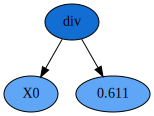

In [48]:
if symbolic_classification:
    symbolic_clas, est_gp  = symbolic_classifier(random_forest_model, 
                                                     data=X_train,
                                                     hyperparams=symbolic_classification_hyperparams)
         
        
    y_test_symbolic_clas = np.round(np.clip(calculate_function_values_from_sympy(symbolic_clas, X_test), 0, 1)).astype(np.int64).reshape(-1,1)

    y_test_model = random_forest_model.predict(X_test).reshape(-1,1)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_symbolic_class_performance = accuracy_score(y_test, y_test_symbolic_clas) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_symbolic_clas)     
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_symbolic_class_performance = f1_score(y_test, y_test_symbolic_clas) 
    
    f1_fidelity = f1_score(y_test_model, y_test_symbolic_clas)     
        
    print('Program Length: ', est_gp.run_details_['best_length'][-1])
    display(symbolic_clas)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Classification:', accuracy_symbolic_class_performance)
    
    print('Fidelity (Accuracy) Symbolic Classification - Random Forest Model:', accuracy_fidelity)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Classification:', f1_symbolic_class_performance)
    
    print('Fidelity (F1 Score) Symbolic Classification - Random Forest Model:', f1_fidelity)
    
    graph_data = est_gp._program.export_graphviz()
    graph = graphviz.Source(graph_data)
    display(graph)